# Description
## Background and Context

You are a Data Scientist for a tourism company named "Visit with us". The Policy Maker of the company wants to enable and establish a viable business model to expand the customer base.

A viable business model is a central concept that helps you to understand the existing ways of doing the business and how to change the ways for the benefit of the tourism sector.

One of the ways to expand the customer base is to introduce a new offering of packages.

Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages.

However, the marketing cost was quite high because customers were contacted at random without looking at the available information.

The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being.

However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.

You as a Data Scientist at "Visit with us" travel company have to analyze the customers' data and information to provide recommendations to the Policy Maker and Marketing Team and also build a model to predict the potential customer who is going to purchase the newly introduced travel package.

## Objective

To predict which customer is more likely to purchase the newly introduced travel package.

## Data Dictionary

**Customer details**:

- CustomerID: Unique customer ID
- ProdTaken: Whether the customer has purchased a package or not (0: No, 1: Yes)
- Age: Age of customer
- TypeofContact: How customer was contacted (Company Invited or Self Inquiry)
- CityTier: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3
- Occupation: Occupation of customer
- Gender: Gender of customer
- NumberOfPersonVisiting: Total number of persons planning to take the trip with the customer
- PreferredPropertyStar: Preferred hotel property rating by customer
- MaritalStatus: Marital status of customer
- NumberOfTrips: Average number of trips in a year by customer
- Passport: The customer has a passport or not (0: No, 1: Yes)
- OwnCar: Whether the customers own a car or not (0: No, 1: Yes)
- NumberOfChildrenVisiting: Total number of children with age less than 5 planning to take the trip with the customer
- Designation: Designation of the customer in the current organization
- MonthlyIncome: Gross monthly income of the customer

**Customer interaction data**: 

- PitchSatisfactionScore: Sales pitch satisfaction score
- ProductPitched: Product pitched by the salesperson
- NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
- DurationOfPitch: Duration of the pitch by a salesperson to the customer

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
## import plotly.graph_objects as go
import re
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

sns.set(rc={'figure.figsize':(12,9)})

## Read the dataset

In [2]:
# Read excel and rename a few columns for better read
travel_history_df = pd.read_excel('Tourism.xlsx',sheet_name='Tourism')
travel_history_df.columns = [re.sub(r'(?<!^)(?=[A-Z][a-z])', '_', col.replace(' ', '')).lower() for col in travel_history_df.columns]
travel_history_df.rename(columns = {'typeof_contact': 'type_of_contact'}, inplace=True)
travel_history_df.head()

,customerid,prod_taken,age,type_of_contact,city_tier,duration_of_pitch,occupation,gender,number_of_person_visiting,number_of_followups,product_pitched,preferred_property_star,marital_status,number_of_trips,passport,pitch_satisfaction_score,own_car,number_of_children_visiting,designation,monthly_income
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


# Exploratory Data Analysis

In [3]:
## Remove customer ID as its not required for modelling or joining any data sets
travel_history_df.drop(columns='customerid', inplace=True) 
for col in travel_history_df.columns:
    print(f"\t, '{col}'")

	, 'prod_taken'
	, 'age'
	, 'type_of_contact'
	, 'city_tier'
	, 'duration_of_pitch'
	, 'occupation'
	, 'gender'
	, 'number_of_person_visiting'
	, 'number_of_followups'
	, 'product_pitched'
	, 'preferred_property_star'
	, 'marital_status'
	, 'number_of_trips'
	, 'passport'
	, 'pitch_satisfaction_score'
	, 'own_car'
	, 'number_of_children_visiting'
	, 'designation'
	, 'monthly_income'


## Divide the columns into numerical , ordinal and categorical

In [4]:
target_col = 'prod_taken'
numerical_columns = [
    'age'
    , 'duration_of_pitch'
    , 'number_of_person_visiting'
    , 'number_of_followups'
    , 'number_of_trips'
    , 'number_of_children_visiting'
    , 'monthly_income'
]
ordinal_columns = [
    'city_tier'
    , 'preferred_property_star'
    , 'pitch_satisfaction_score'
]
categorical_columns= [
    'type_of_contact'
    , 'occupation'
    , 'gender'
    , 'product_pitched'
    , 'marital_status'
    , 'passport'
    , 'own_car'
    , 'designation'
]


len(travel_history_df.columns) == len(numerical_columns + ordinal_columns + categorical_columns + [target_col])

True

In [5]:
# Check the value Target column

travel_history_df[target_col].value_counts()

0    3968
1     920
Name: prod_taken, dtype: int64

In [6]:
# Check the datatype
travel_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 19 columns):
prod_taken                     4888 non-null int64
age                            4662 non-null float64
type_of_contact                4863 non-null object
city_tier                      4888 non-null int64
duration_of_pitch              4637 non-null float64
occupation                     4888 non-null object
gender                         4888 non-null object
number_of_person_visiting      4888 non-null int64
number_of_followups            4843 non-null float64
product_pitched                4888 non-null object
preferred_property_star        4862 non-null float64
marital_status                 4888 non-null object
number_of_trips                4748 non-null float64
passport                       4888 non-null int64
pitch_satisfaction_score       4888 non-null int64
own_car                        4888 non-null int64
number_of_children_visiting    4822 non-null float64
designati

In [7]:
# Check rows and columns
travel_history_df.shape

(4888, 19)

In [8]:
# Sample data
travel_history_df

,prod_taken,age,type_of_contact,city_tier,duration_of_pitch,occupation,gender,number_of_person_visiting,number_of_followups,product_pitched,preferred_property_star,marital_status,number_of_trips,passport,pitch_satisfaction_score,own_car,number_of_children_visiting,designation,monthly_income
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0
4884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Basic,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0
4885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0
4886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Basic,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0


## Calculate the nulls and uniques

In [9]:
def calculate_nulls_and_uniques(df):

    nulls_and_uniques = pd.DataFrame(
        {
            'NULL_count': travel_history_df.isna().sum()
            , 'UNIQUE_count': travel_history_df.nunique()
            , 'null_value_%': travel_history_df.isna().sum() / len(travel_history_df)
        }
    )
    nulls_and_uniques.sort_values('NULL_count', ascending=False, inplace=True)
    return nulls_and_uniques
    
calculate_nulls_and_uniques(travel_history_df)

,NULL_count,UNIQUE_count,null_value_%
duration_of_pitch,251,34,0.051350
monthly_income,233,2475,0.047668
age,226,44,0.046236
number_of_trips,140,12,0.028642
number_of_children_visiting,66,4,0.013502
number_of_followups,45,6,0.009206
preferred_property_star,26,3,0.005319
type_of_contact,25,2,0.005115
designation,0,5,0.000000
own_car,0,2,0.000000


In [10]:
travel_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
prod_taken,4888.0,0.188216,0.390925,0.0,0.0,0.0,0.0,1.0
age,4662.0,37.622265,9.316387,18.0,31.0,36.0,44.0,61.0
city_tier,4888.0,1.654255,0.916583,1.0,1.0,1.0,3.0,3.0
duration_of_pitch,4637.0,15.490835,8.519643,5.0,9.0,13.0,20.0,127.0
number_of_person_visiting,4888.0,2.905074,0.724891,1.0,2.0,3.0,3.0,5.0
number_of_followups,4843.0,3.708445,1.002509,1.0,3.0,4.0,4.0,6.0
preferred_property_star,4862.0,3.581037,0.798009,3.0,3.0,3.0,4.0,5.0
number_of_trips,4748.0,3.236521,1.849019,1.0,2.0,3.0,4.0,22.0
passport,4888.0,0.290917,0.454232,0.0,0.0,0.0,1.0,1.0
pitch_satisfaction_score,4888.0,3.078151,1.365792,1.0,2.0,3.0,4.0,5.0


## Univriate Analysis

### Count Plot of Ordinal columns

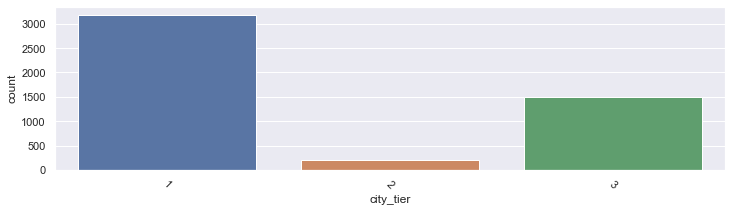

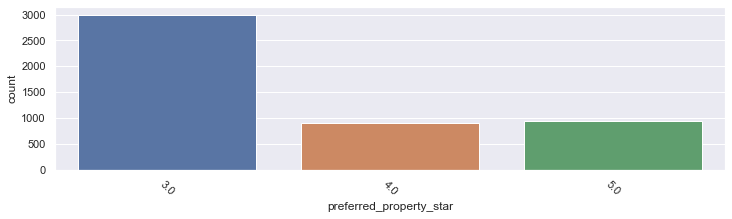

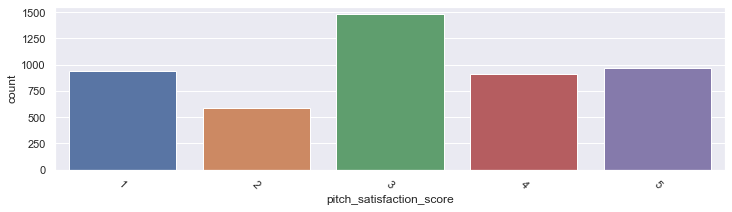

In [11]:
for col in ordinal_columns:
    sns.set({'figure.figsize':(12,3)})
    counts = sns.countplot(x=travel_history_df[col])
    plt.xticks(rotation=-45)
    plt.show()

### Change "Fe Male" to "Female"

In [12]:
travel_history_df['gender'] = ['Female' if gender == 'Fe Male' else gender for gender in travel_history_df['gender']]

### Count plot on Categorical columns

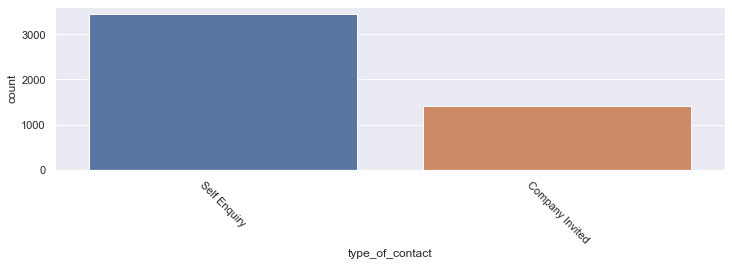

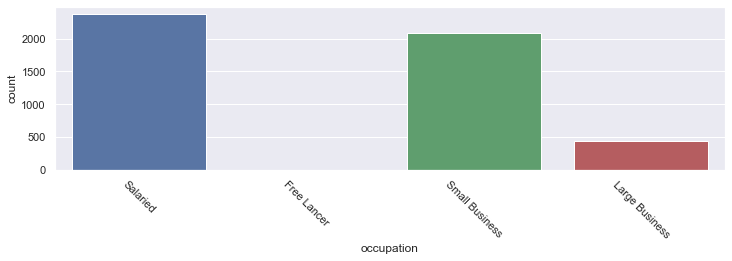

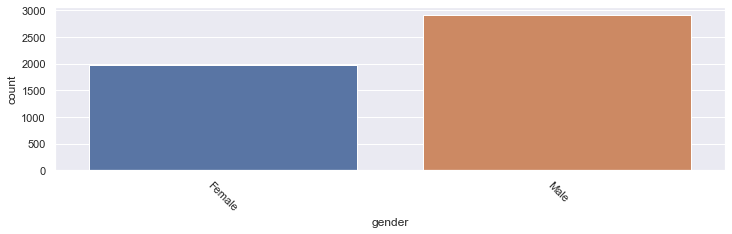

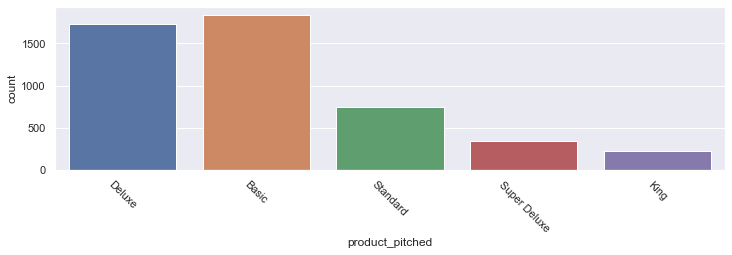

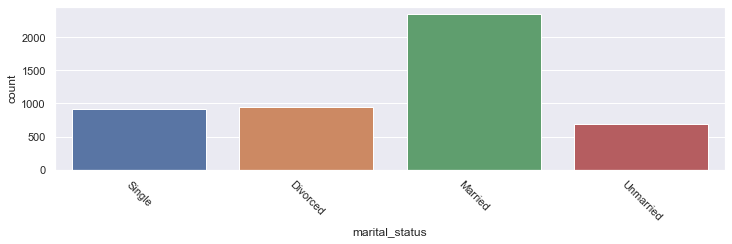

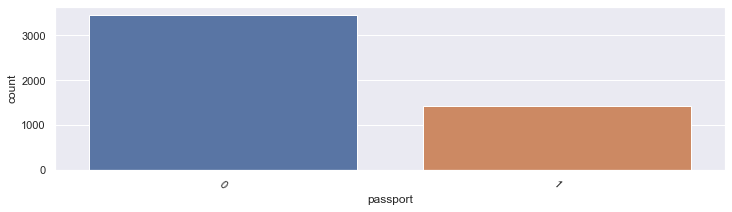

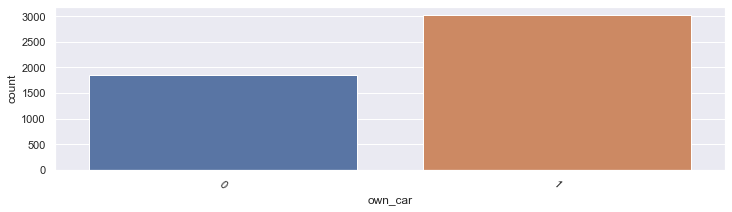

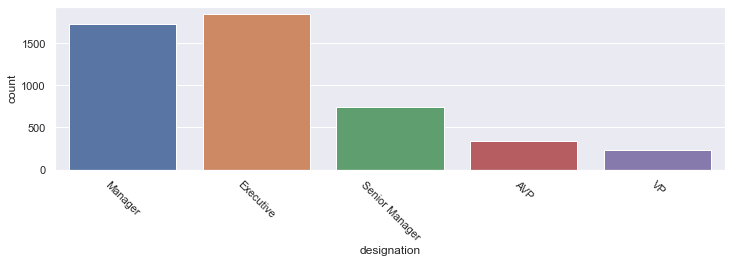

In [13]:
for col in categorical_columns:
    sns.set({'figure.figsize':(12,3)})
    counts = sns.countplot(x=travel_history_df[col])
    plt.xticks(rotation=-45)
    plt.show()

### Hist Plot on Ordinal columns

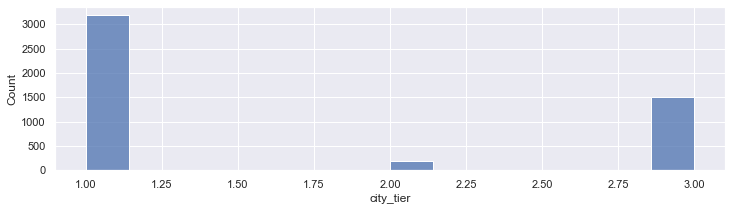

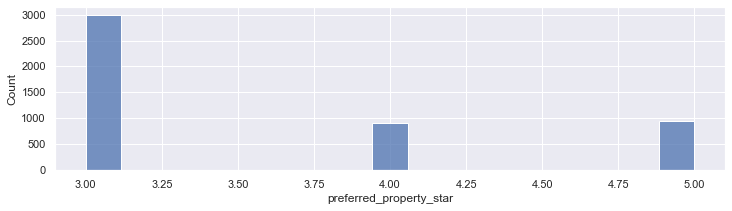

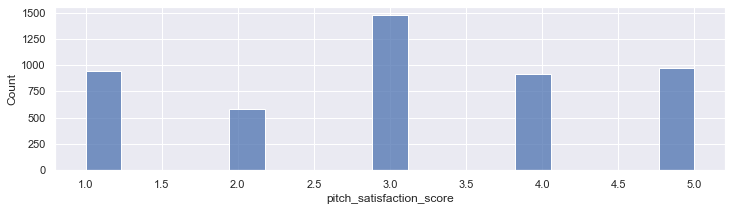

In [14]:
for col in ordinal_columns:
    sns.histplot(x=travel_history_df[col])
    plt.show()

### Function for Hist and Box plot

In [15]:
def hist_and_box(data):
    _, (ax_box, ax_hist) = plt.subplots(nrows=2
                                        , sharex=True
                                        , gridspec_kw={"height_ratios": (.15, .85)}
                                        , figsize=(12,5)
                                        )

    sns.boxplot(x=data, ax=ax_box)
    sns.histplot(x=data, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()
    

### Histogram and Box plot on Numerical data

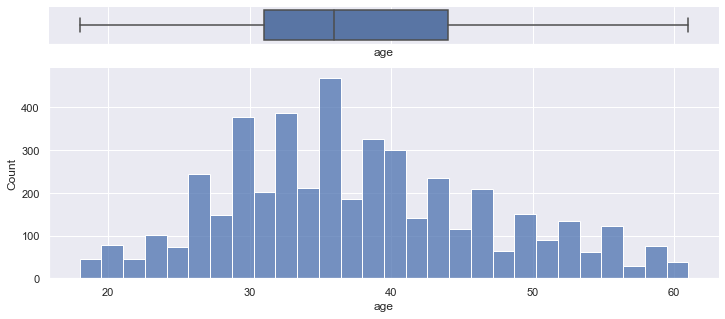

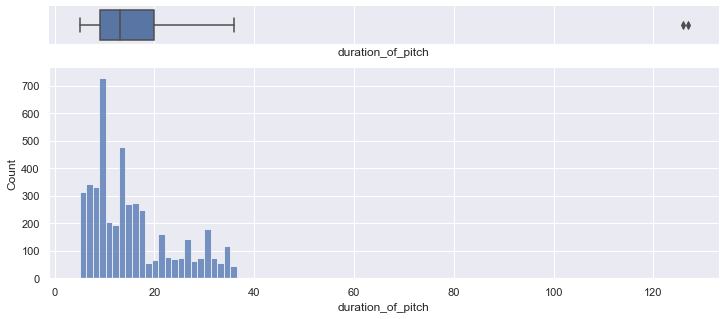

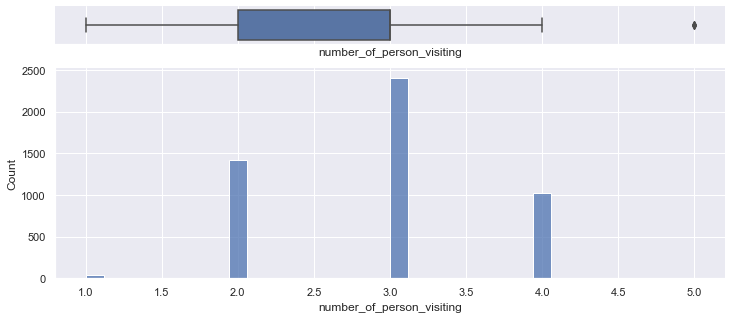

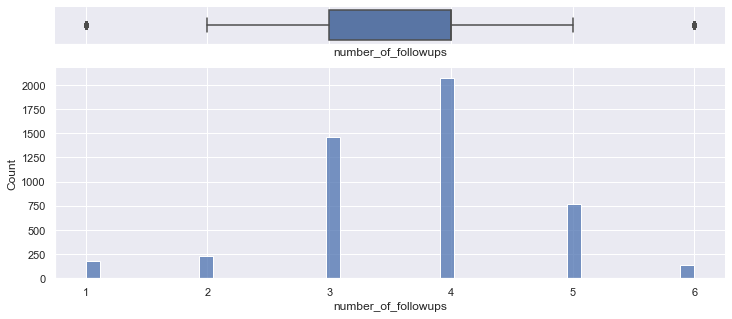

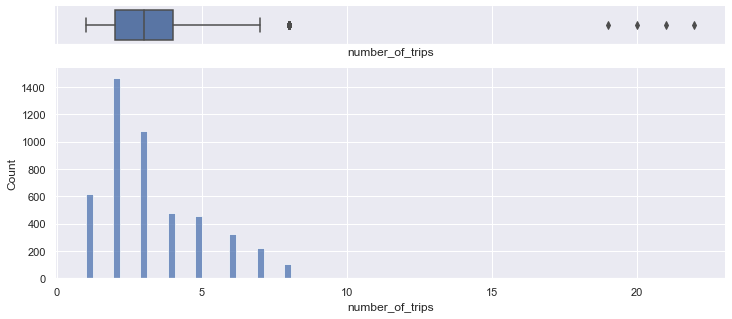

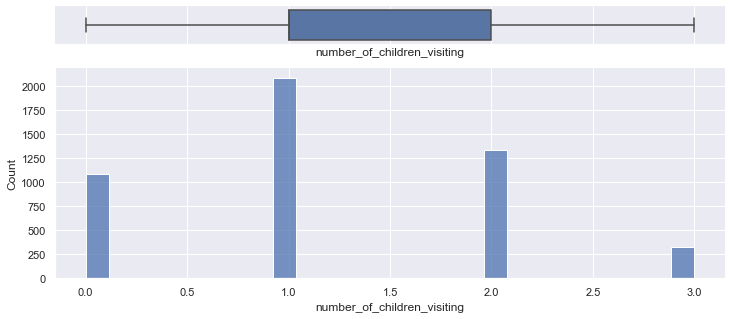

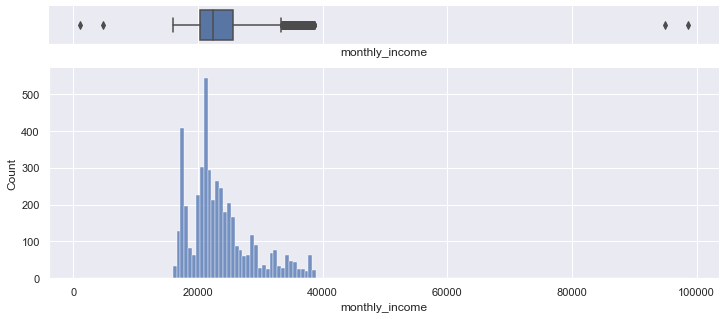

In [16]:
for col in numerical_columns:
    hist_and_box(travel_history_df[col])

## Observations from Univariate Analysis :

- `gender` has a type of Fe Male instead of Female - This needs to be fixed in data processing unit
- `Married` couple are highest
- `Self-employed` is much more than `salaried`
- Outliers in `duration_of_pitch` and `number_of_trips`
- Approx 5% `age` and `duration_of_pitch` are null

## Bi-variate/Multivariate Analysis

### Scatter plot on age and monthly income

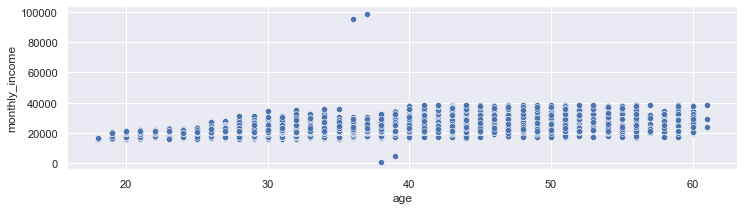

In [17]:
sns.scatterplot(
    x='age'
    , y='monthly_income'
    , data=travel_history_df)
plt.show()

### Heatmap correlation

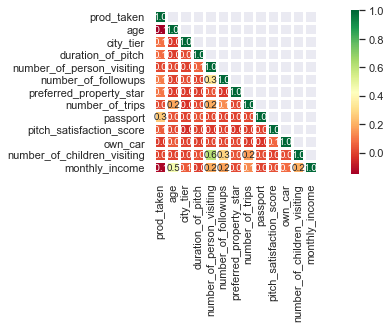

In [18]:
corr = travel_history_df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

sns.heatmap(corr,mask=mask,annot=True, square=True,fmt='.1f',cmap='RdYlGn', linewidths=2)
plt.show()

### Pairplot with all variables

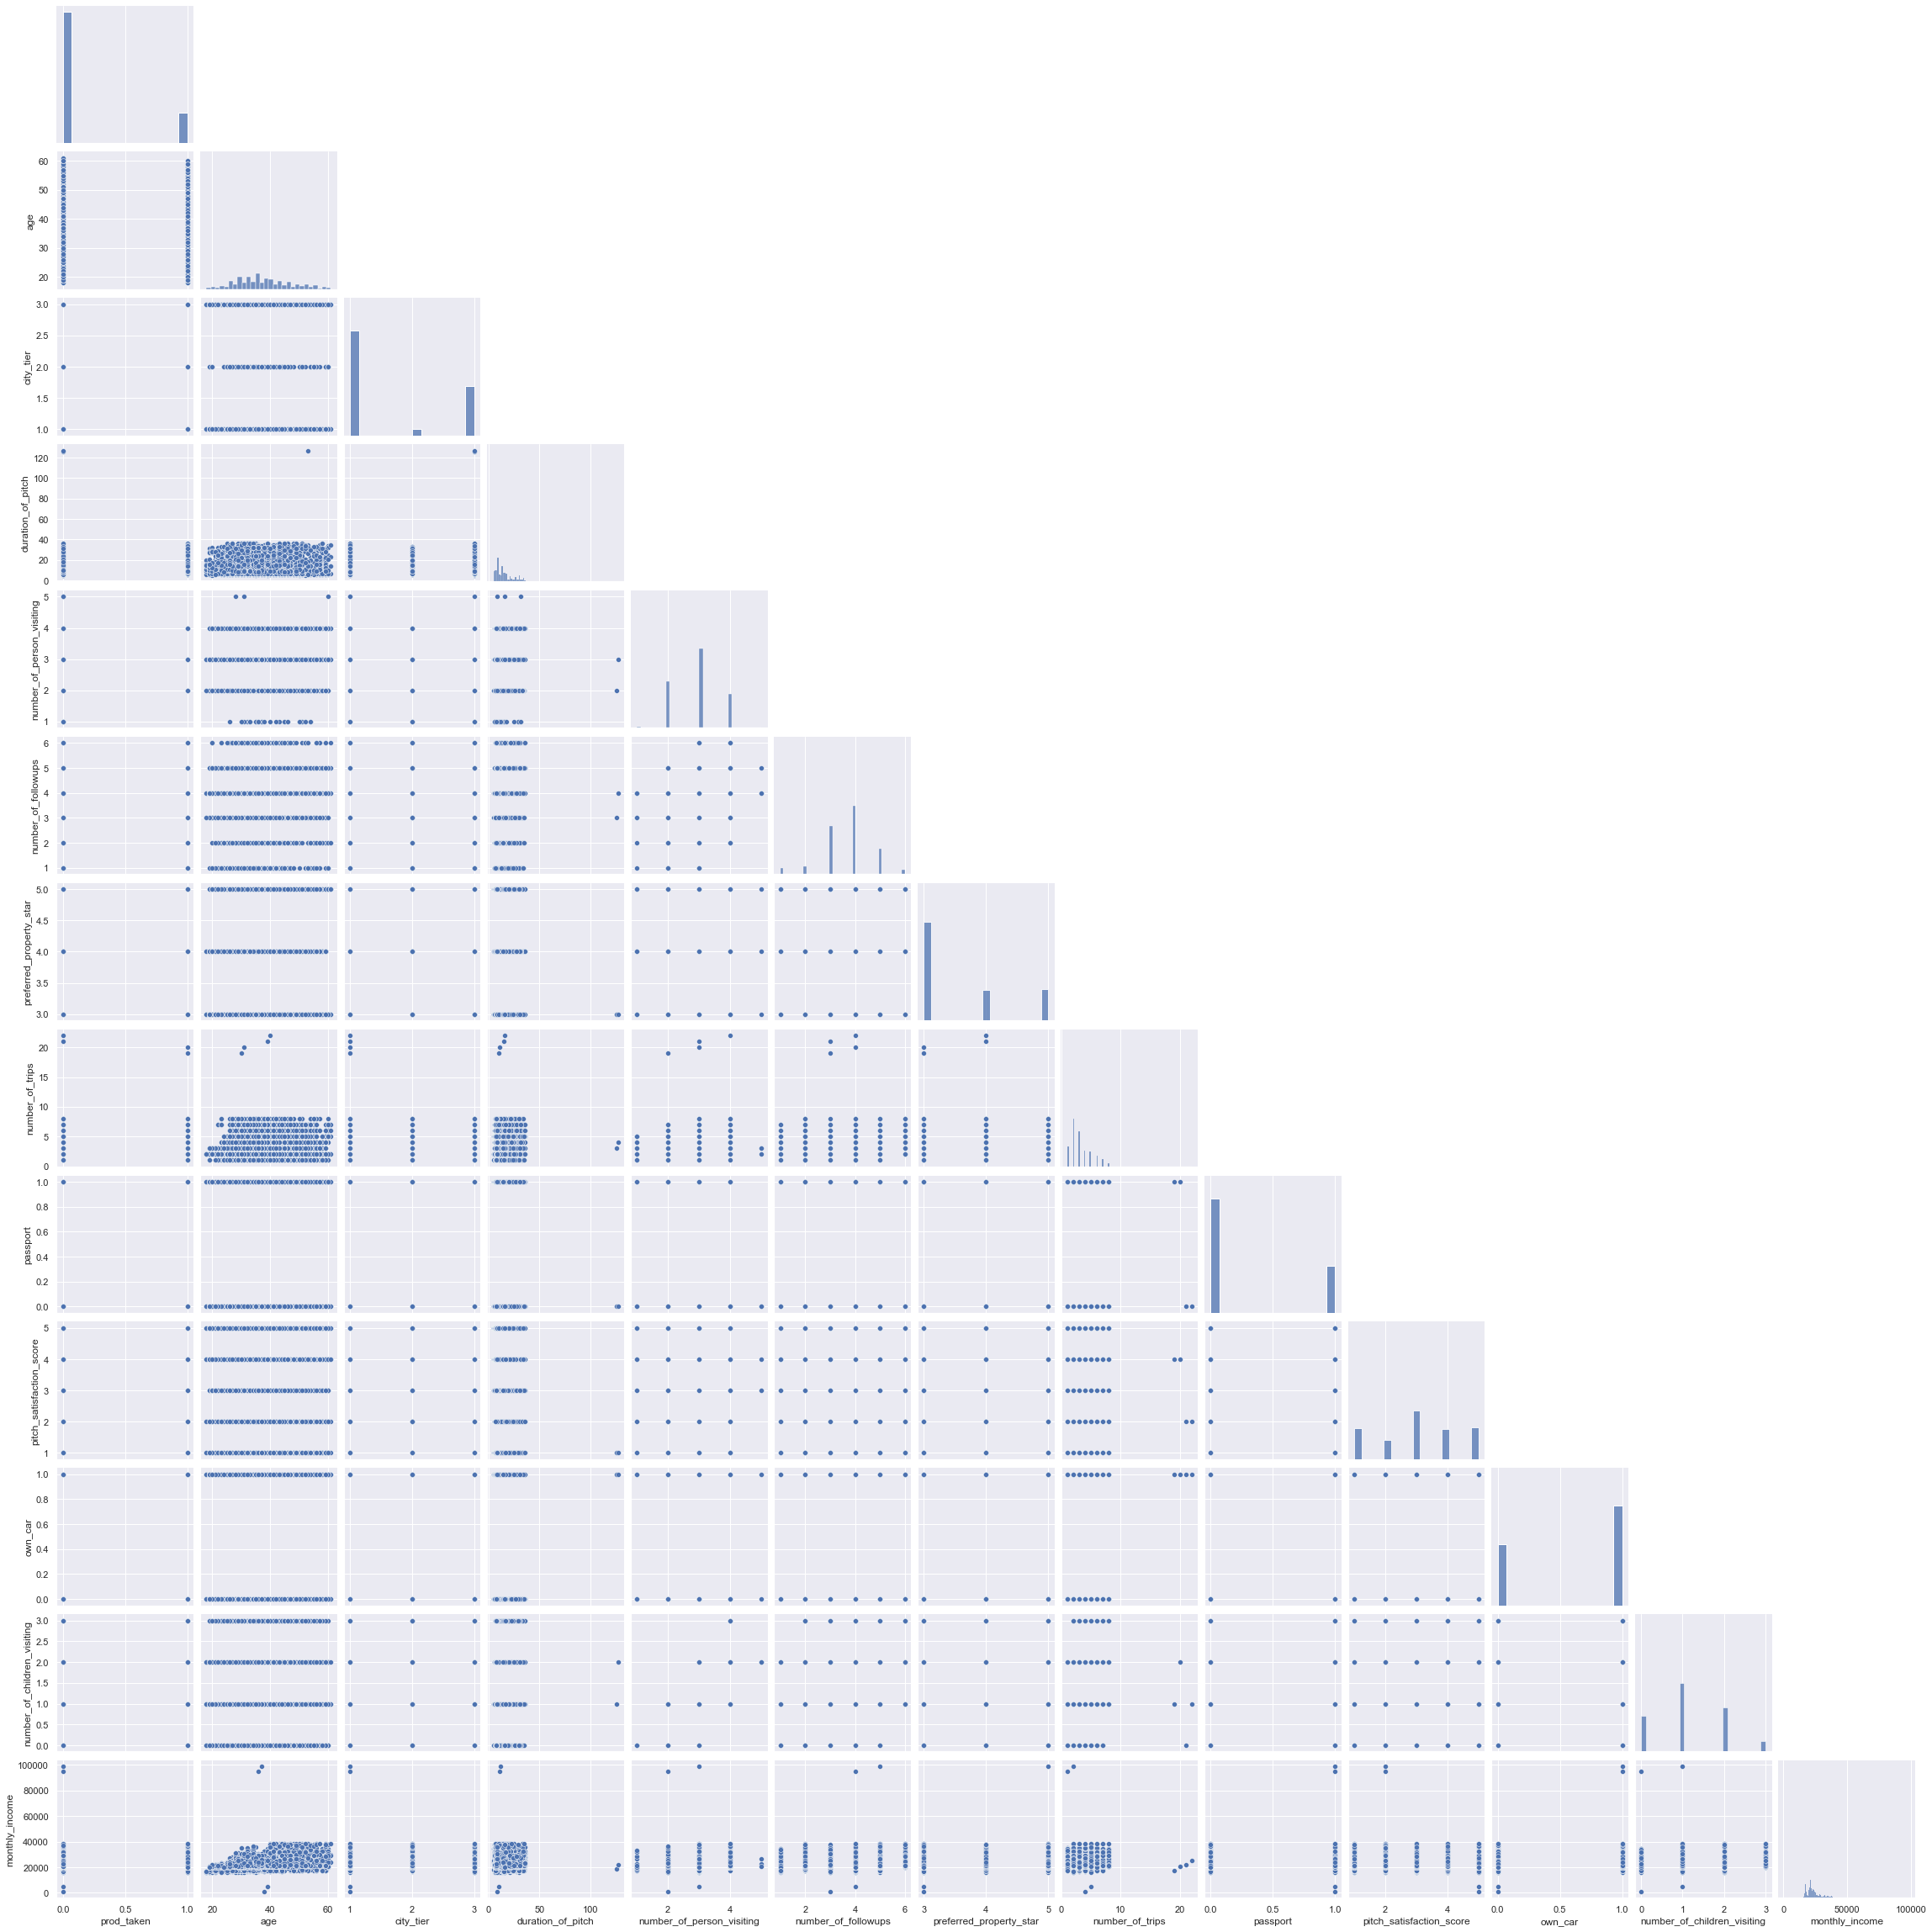

In [19]:
sns.pairplot(travel_history_df,corner=True)
plt.show()

## Observation from Bivariate analysis:

- `passport` correlations strongest to target variable
- `age` and `monthly_income` have a relationship
- `number_of_persons` and `number_of_followups` has a weak relationship 
- Number of trips also as very weak relationships


## Data Pre-processing

In [20]:
## Calculate the nulls and unique

calculate_nulls_and_uniques(travel_history_df)

,NULL_count,UNIQUE_count,null_value_%
duration_of_pitch,251,34,0.051350
monthly_income,233,2475,0.047668
age,226,44,0.046236
number_of_trips,140,12,0.028642
number_of_children_visiting,66,4,0.013502
number_of_followups,45,6,0.009206
preferred_property_star,26,3,0.005319
type_of_contact,25,2,0.005115
designation,0,5,0.000000
own_car,0,2,0.000000


In [21]:
## I am dropping the number of children because of nulls and correlation to number of person visited since person (which has zero nulls). However, the business user may not want market wellness trip to a family. So we should keep this in mind.
travel_history_df.drop(columns='number_of_children_visiting', inplace=True)

In [22]:
# Replace null monthly income by grouping data with age and use the median

monthly_income_fill_values = travel_history_df.groupby('age').agg({'monthly_income': 'median'}).rename(columns={'monthly_income': 'monthly_income_replace'}).reset_index()
travel_history_df = travel_history_df.merge(monthly_income_fill_values, on='age', how='left')
for i in travel_history_df.index:
    if np.isnan(travel_history_df.loc[i, 'monthly_income']):
        travel_history_df.loc[i, 'monthly_income'] = travel_history_df.loc[i, 'monthly_income_replace']
travel_history_df.drop(columns=['age', 'monthly_income_replace'], inplace=True)

In [23]:
# Replace Nulls with median for monthly income , duration of pitch , number of trips

cols_to_replace_nulls_w_median = [
    'monthly_income'
    , 'duration_of_pitch'
    , 'number_of_trips'
]

# Dop columns type of contact, preferred property star, number of followups

cols_to_drop_nulls = [
    'type_of_contact' 
    , 'preferred_property_star'
    , 'number_of_followups'
]

for col in cols_to_replace_nulls_w_median:
    travel_history_df[col].fillna(travel_history_df[col].median(), inplace=True)

travel_history_df.dropna(subset=cols_to_drop_nulls, inplace=True)

calculate_nulls_and_uniques(travel_history_df)

,NULL_count,UNIQUE_count,null_value_%
prod_taken,0,2,0.0
preferred_property_star,0,3,0.0
designation,0,5,0.0
own_car,0,2,0.0
pitch_satisfaction_score,0,5,0.0
passport,0,2,0.0
number_of_trips,0,12,0.0
marital_status,0,4,0.0
product_pitched,0,5,0.0
type_of_contact,0,2,0.0


## Outliers

### Analysis on No of trips , Duration of pitch , MOnthly income

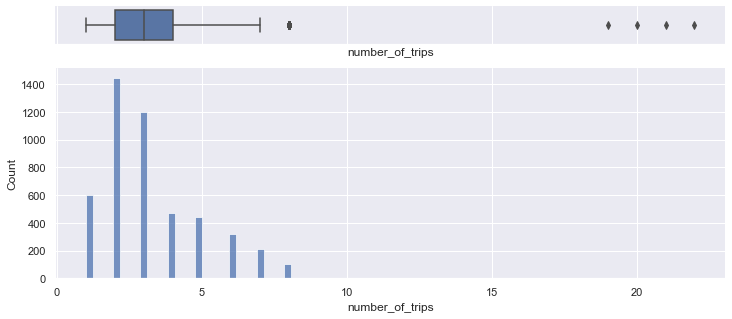

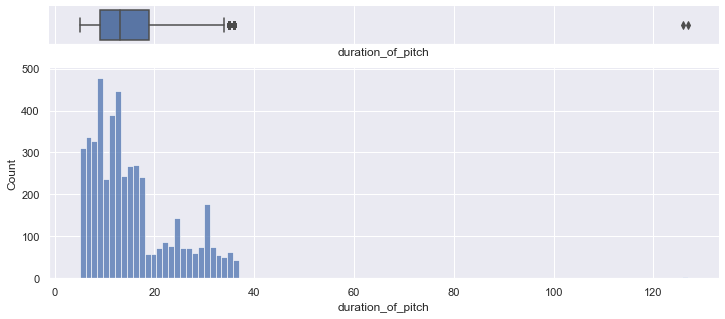

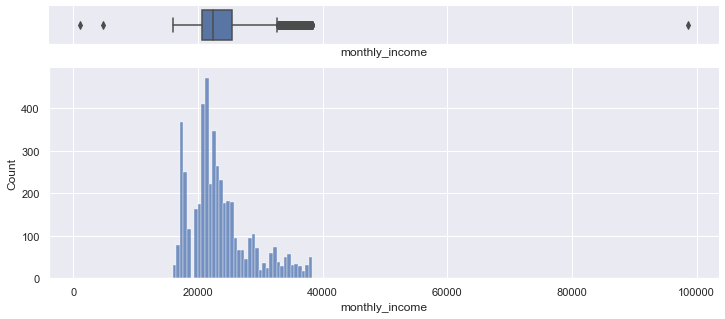

In [24]:
cols_w_outliers = [ 
    'number_of_trips'
    , 'duration_of_pitch'
    , 'monthly_income'
]
for col in cols_w_outliers:
    hist_and_box(travel_history_df[col])

In [25]:
## By looking at the above chart , we can have threshold as 
## number_of_trips_threshold = 9
## duration_of_pitch_threshold = 40
## monthly_income_threhold = 40000

number_of_trips_threshold = 9
print("Outlier Data points number_of_trips_threhold :", len(travel_history_df[travel_history_df['number_of_trips'] > number_of_trips_threshold]))

duration_of_pitch_threshold = 40
print("Outlier Data points duration_of_pitch_threhold :",len(travel_history_df[travel_history_df['duration_of_pitch'] > duration_of_pitch_threshold]))

monthly_income_threshold = 40000
print("Outlier Data points monthly_income_threshold :",len(travel_history_df[travel_history_df['monthly_income'] > monthly_income_threshold]))

Outlier Data points number_of_trips_threhold : 4
Outlier Data points duration_of_pitch_threhold : 2
Outlier Data points monthly_income_threshold : 1


### Remove the outliers

In [26]:
number_of_trips_replace = max(travel_history_df[travel_history_df['number_of_trips'] < number_of_trips_threshold]['number_of_trips'])
travel_history_df['number_of_trips'] = [number_of_trips_replace if x > number_of_trips_threshold else x for x in travel_history_df['number_of_trips'] ]

duration_of_pitch_replace = max(travel_history_df[travel_history_df['duration_of_pitch'] < duration_of_pitch_threshold]['duration_of_pitch'])
travel_history_df['duration_of_pitch'] = [duration_of_pitch_replace if x > duration_of_pitch_threshold else x for x in travel_history_df['duration_of_pitch']]


monthly_income_replace = max(travel_history_df[travel_history_df['monthly_income'] < monthly_income_threshold]['monthly_income'])
travel_history_df['monthly_income'] = [monthly_income_replace if x > monthly_income_threshold else x for x in travel_history_df['monthly_income']]


### Box plot and Histogram after outlier removal

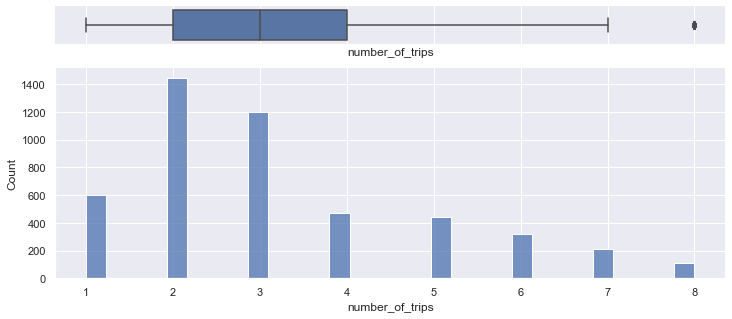

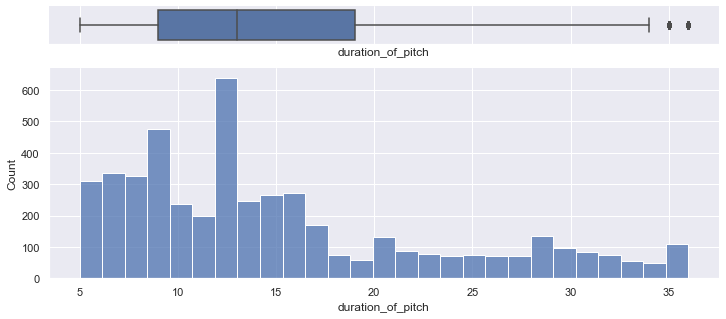

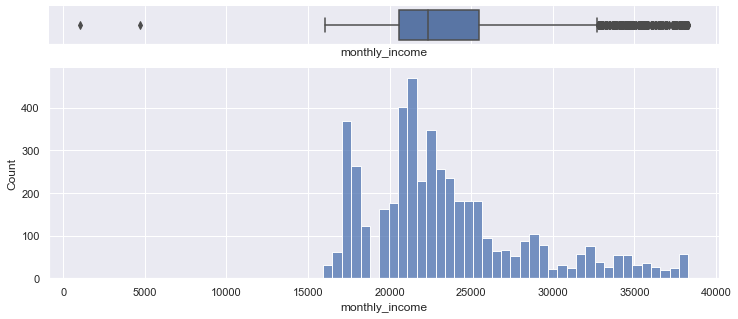

In [27]:
for col in cols_w_outliers:
    hist_and_box(travel_history_df[col])

## Describe: After outlier treatment & data processing

In [28]:
travel_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
prod_taken,4792.0,0.188439,0.391103,0.0,0.0,0.0,0.00,1.0
city_tier,4792.0,1.652546,0.916293,1.0,1.0,1.0,3.00,3.0
duration_of_pitch,4792.0,15.356219,8.048576,5.0,9.0,13.0,19.00,36.0
number_of_person_visiting,4792.0,2.909015,0.723279,1.0,2.0,3.0,3.00,5.0
number_of_followups,4792.0,3.706177,0.999091,1.0,3.0,4.0,4.00,6.0
preferred_property_star,4792.0,3.581386,0.797913,3.0,3.0,3.0,4.00,5.0
number_of_trips,4792.0,3.218698,1.755024,1.0,2.0,3.0,4.00,8.0
passport,4792.0,0.293406,0.455370,0.0,0.0,0.0,1.00,1.0
pitch_satisfaction_score,4792.0,3.075125,1.365936,1.0,2.0,3.0,4.00,5.0
own_car,4792.0,0.618948,0.485696,0.0,0.0,1.0,1.00,1.0


## Convert Categorical data into dummy or indicator variables

In [29]:
numerical_columns = list(travel_history_df.describe().T.index)
columns_to_dummy = [col for col in travel_history_df.columns if col not in numerical_columns]
travel_history_df[columns_to_dummy].head()
travel_history_df = pd.get_dummies(travel_history_df, columns=columns_to_dummy, drop_first=True)
travel_history_df.columns = [re.sub(r'(?<!^)(?=[A-Z][a-z])', '_', col.replace(' ', '')).lower().replace('__', '_') for col in travel_history_df.columns]
travel_history_df.head()

,prod_taken,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,own_car,monthly_income,type_of_contact_self_enquiry,occupation_large_business,occupation_salaried,occupation_small_business,gender_male,product_pitched_deluxe,product_pitched_king,product_pitched_standard,product_pitched_super_deluxe,marital_status_married,marital_status_single,marital_status_unmarried,designation_executive,designation_manager,designation_senior_manager,designation_vp
0,1,3,6.0,3,3.0,3.0,1.0,1,2,1,20993.0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,1,14.0,3,4.0,4.0,2.0,0,3,1,20130.0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
2,1,1,8.0,3,4.0,3.0,7.0,1,3,0,17090.0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,0,1,9.0,2,3.0,3.0,2.0,1,5,1,17909.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,8.0,2,3.0,4.0,1.0,0,5,1,18468.0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0


## View dataset after getting dummy value

In [30]:
travel_history_df.head()

,prod_taken,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,own_car,monthly_income,type_of_contact_self_enquiry,occupation_large_business,occupation_salaried,occupation_small_business,gender_male,product_pitched_deluxe,product_pitched_king,product_pitched_standard,product_pitched_super_deluxe,marital_status_married,marital_status_single,marital_status_unmarried,designation_executive,designation_manager,designation_senior_manager,designation_vp
0,1,3,6.0,3,3.0,3.0,1.0,1,2,1,20993.0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,1,14.0,3,4.0,4.0,2.0,0,3,1,20130.0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
2,1,1,8.0,3,4.0,3.0,7.0,1,3,0,17090.0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,0,1,9.0,2,3.0,3.0,2.0,1,5,1,17909.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,8.0,2,3.0,4.0,1.0,0,5,1,18468.0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0


# Build ML Model

A few words on Recall and Precision : 

- Recall: Recall gives us an idea about when it’s actually yes, how often does it predict yes.
- Recall = TP / (TP + FN)
---------------------------------------------------------------------------------
- Precsion tells us about when it predicts yes, how often is it correct.
- Precision = TP / (TP + FP)


**In our use-case , Precision seems more important than recall as we want to see how often our predicted value is correct**


## Split dataset to train and test

In [31]:
## all df cols for training but the target column
X_cols = list(travel_history_df.columns) 
X_cols.remove(target_col)

X = travel_history_df[X_cols]
y = travel_history_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=3,stratify=y)

##  Bagging

### Function for confusion matrix

In [32]:
def display_confusion_matrix(y_test, y_pred):
    confusion_martix = metrics.confusion_matrix(y_test, y_pred)

    sns.set({'figure.figsize':(8,5)})
    sns.heatmap(confusion_martix, annot=True, fmt='.0f', xticklabels=[0,1], yticklabels=[0,1])
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

def analyze_model_performance(model, model_name, X_train, y_train, X_test, y_test, display_results=True):
    y_pred = model.predict(X_test)
    performance_metrics = {
        'model_name': model_name
        , 'training_accuracy': model.score(X_train, y_train)
        , 'testing_accuracy': model.score(X_test, y_test)
        , 'precision': metrics.precision_score(y_test, y_pred)
        , 'recall': metrics.recall_score(y_test, y_pred)
        , 'f1_score': metrics.f1_score(y_test, y_pred)
        , 'roc_auc_score': metrics.roc_auc_score(y_test, y_pred)
    }
    if display_results:
        for key in performance_metrics.keys():
            if key == 'model_name':
                display_value = performance_metrics[key]
            else: 
                display_value = round(performance_metrics[key], 3)
            print(f'{key}: {display_value}')
        display_confusion_matrix(y_test, y_pred)
    return performance_metrics


In [33]:
all_models_performance = []

### Decision Trees

model_name: decision tree
training_accuracy: 1.0
testing_accuracy: 0.893
precision: 0.705
recall: 0.742
f1_score: 0.723
roc_auc_score: 0.835


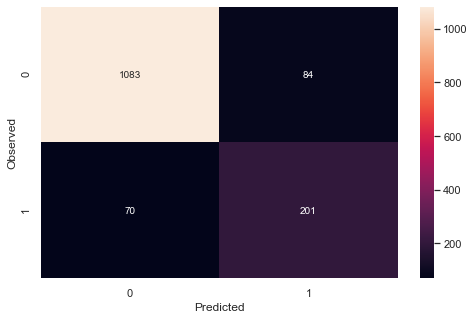

In [34]:
model_name = 'decision tree'
decision_tree_model = DecisionTreeClassifier(criterion='gini', random_state=3)
decision_tree_model.fit(X_train, y_train)
model_performance = analyze_model_performance(decision_tree_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Decision Tree
- It seems the model is overfit
- Precision as 0.7 seems a bit low
- Need to be tuned and observe the results

### Bagging

model_name: bagging
training_accuracy: 0.993
testing_accuracy: 0.909
precision: 0.872
recall: 0.605
f1_score: 0.715
roc_auc_score: 0.792


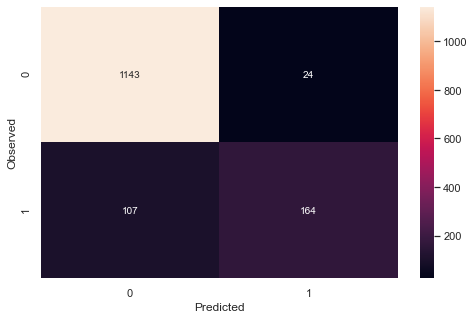

In [35]:
model_name = 'bagging'
bagging_model = BaggingClassifier(random_state=3)
bagging_model.fit(X_train, y_train)
model_performance = analyze_model_performance(bagging_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Bagging
- It seems the model is slightly overfit but better than Decision trees
- Precision is much better than Decision tree

### Random Forest

model_name: random forest
training_accuracy: 0.993
testing_accuracy: 0.909
precision: 0.872
recall: 0.605
f1_score: 0.715
roc_auc_score: 0.792


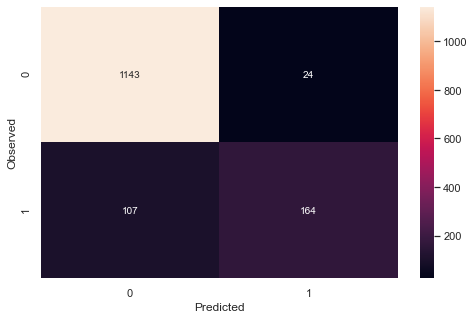

In [36]:
model_name = 'random forest'
random_forest_model = RandomForestClassifier(random_state=3)
random_forest_model.fit(X_train, y_train)
model_performance = analyze_model_performance(bagging_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Random forest
- It seems the model is same as Bagging model
- Precision is much better than Decision tree and same as Bagging

The problem definition stated that `the marketing cost was quite high because customers were contacted at random without looking at the available information.`

The previous conversion rate was low at ~20%.  We should be focusing on `precision`. There is a lot of room to improve and narrowing the list can result in huge savings. We want to be able to predict the highest number of potential future customers.

In [37]:
## make_scorer : Make a scorer from a performance metric or loss function.

travel_scorer = metrics.make_scorer(metrics.precision_score)

### Tuning of Decision trees ,Bagging , Random forest

#### Find best estimator 

In [38]:
## Find best estimator

def find_and_train_best_estimator(estimator, hyperparameters_to_test, scorer):
    grid_obj = GridSearchCV(estimator, hyperparameters_to_test)
    grid_obj = grid_obj.fit(X_train, y_train)
    estimator = grid_obj.best_estimator_
    return estimator.fit(X_train, y_train)

#### Decision Tree Tuned

model_name: Tuned Decision tree
training_accuracy: 0.904
testing_accuracy: 0.848
precision: 0.688
recall: 0.351
f1_score: 0.465
roc_auc_score: 0.657


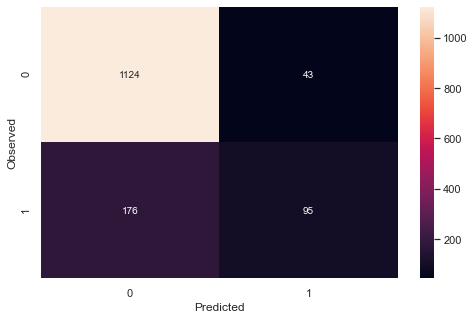

In [39]:
model_name = 'Tuned Decision tree'

decision_tree_model = DecisionTreeClassifier(criterion='gini', random_state=3)
params = {
    'max_depth': np.arange(1,15)
    , 'criterion': ['gini', 'entropy']
    , 'min_impurity_decrease': [0.00001,0.0001,0.001]
    , 'max_features': ['log2','sqrt']
}

decision_tree_model = find_and_train_best_estimator(decision_tree_model, params, travel_scorer)

model_performance = analyze_model_performance(decision_tree_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Tuned Decision Tree
- It seems the model is better than Decision tree without tune
- Precision and Recall are much lower

#### Bagging Tuned

model_name: Tuned Bagging
training_accuracy: 1.0
testing_accuracy: 0.93
precision: 0.917
recall: 0.694
f1_score: 0.79
roc_auc_score: 0.84


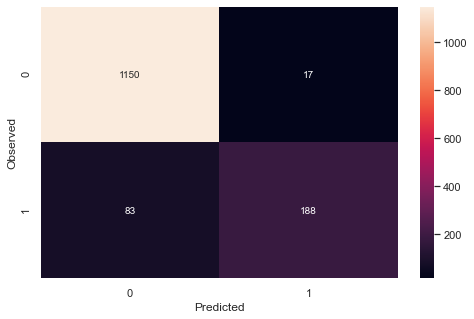

In [40]:
model_name = 'Tuned Bagging'
bagging_model = BaggingClassifier(random_state=3)

params = {
    'n_estimators': [20, 50, 75, 100, 125, 150, 200]
    ,'max_features': [.2, .5, .7, .9]
    ,'max_samples': [.2, .5, .7, .9]
}

bagging_model = find_and_train_best_estimator(bagging_model, params, travel_scorer)

model_performance = analyze_model_performance(bagging_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Tuned Bagging
- It seems the model performed better than original Bagging
- Precision has increased to from 87% to 91% 

model_name: Tuned Random Forest
training_accuracy: 0.965
testing_accuracy: 0.902
precision: 0.887
recall: 0.55
f1_score: 0.679
roc_auc_score: 0.767


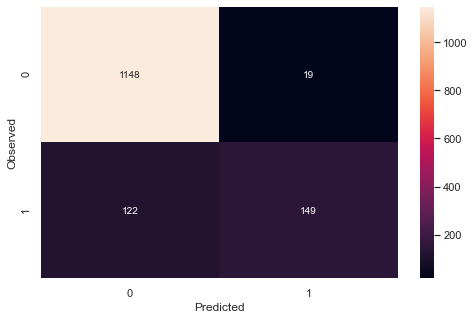

In [41]:
model_name = 'Tuned Random Forest'
random_forest_model = RandomForestClassifier(random_state=1)

params = {
    'n_estimators': [80,90,100,110,120]
    , 'max_depth': [4,6,8,10]
    , 'max_features': ['sqrt','log2',None]
}

random_forest_model = find_and_train_best_estimator(random_forest_model, params, travel_scorer)

model_performance = analyze_model_performance(random_forest_model, model_name, X_train, y_train, X_test, y_test)
all_models_performance.append(model_performance)

#### Observation : Tuned Random forest
- It seems the model performed better than original Bagging
- Precision has increased from 87% to 88.7%

## Boosting

### Function for confusion matrix

In [42]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Function : Accuracy, Recall and Precision

In [43]:
## Calculate : accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [44]:
# import adboost , gbm and xgboost libraries

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

### AdaBoost

In [45]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [46]:
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8452593917710197
Accuracy on test set :  0.8442280945757997
Recall on training set :  0.33069620253164556
Recall on test set :  0.33948339483394835
Precision on training set :  0.6852459016393443
Precision on test set :  0.6715328467153284


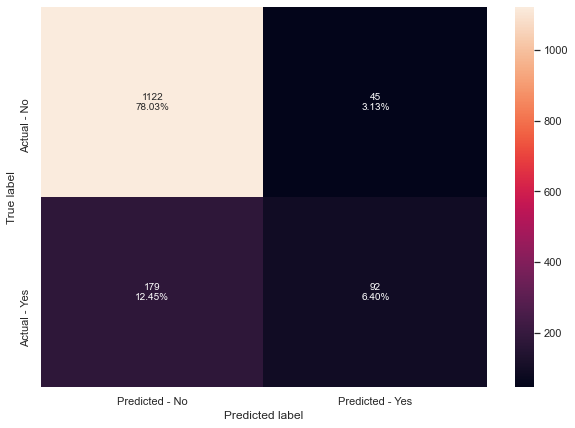

In [47]:
make_confusion_matrix(abc,y_test)

#### Observation : Adaboost
- Model fits well
- Precision on test data is 68% which can be tuned 

#### Feature importance : Adaboost

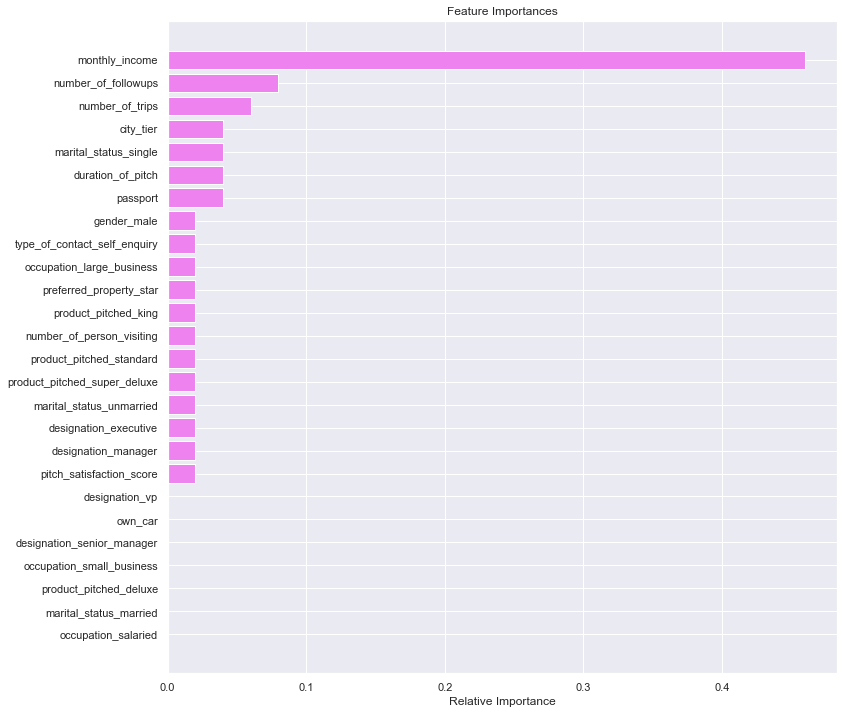

In [48]:
importances = abc.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Gradient Boosting

In [49]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [50]:
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.8822301729278473
Accuracy on test set :  0.8539638386648123
Recall on training set :  0.4541139240506329
Recall on test set :  0.33210332103321033
Precision on training set :  0.8516320474777448
Precision on test set :  0.7563025210084033


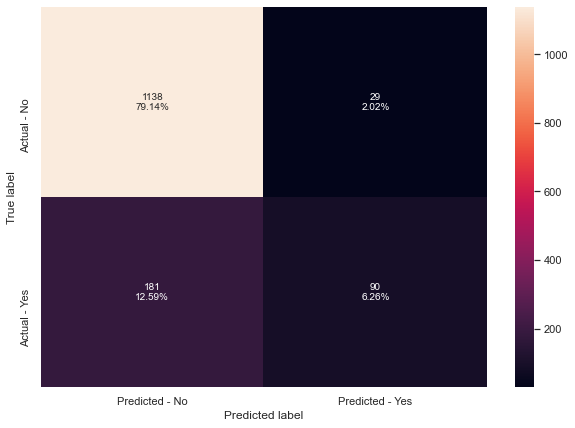

In [51]:
make_confusion_matrix(gbc,y_test)

#### Observation : Gradient Boosting
- Model fits well
- Precision on test data is 75% which can also be tuned 

#### Feature importance : Gradient Boosting

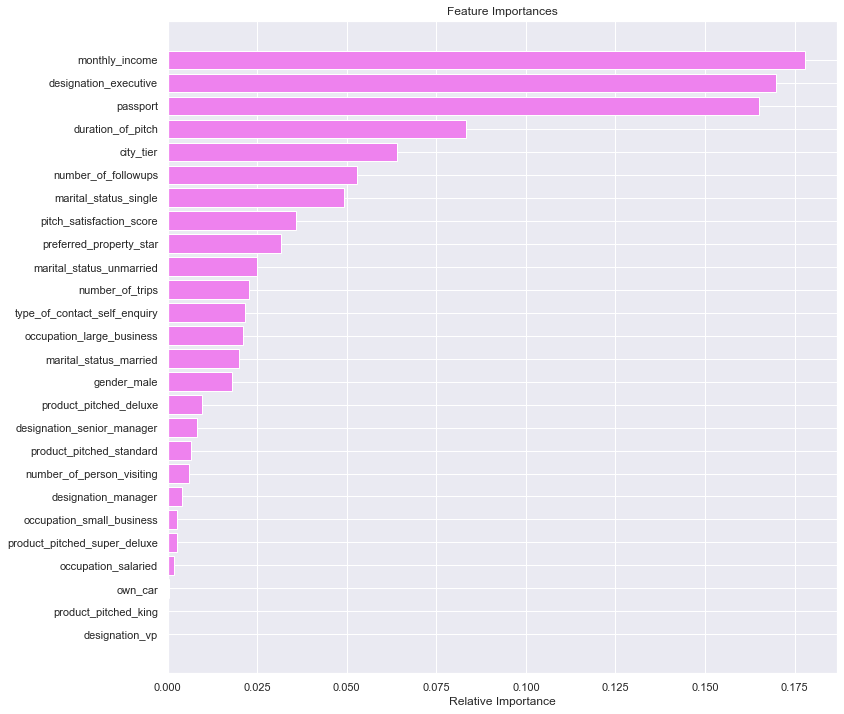

In [52]:
importances = gbc.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [53]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [54]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  0.9985092426952892
Accuracy on test set :  0.9186369958275382
Recall on training set :  0.9920886075949367
Recall on test set :  0.6642066420664207
Precision on training set :  1.0
Precision on test set :  0.8737864077669902


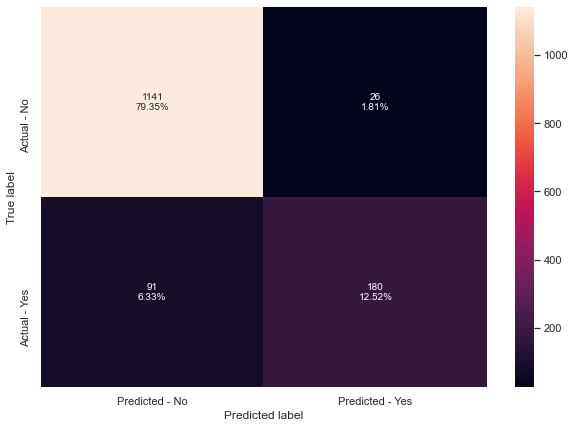

In [55]:
make_confusion_matrix(xgb,y_test)

#### Observation : XgBoost
- Model fits well
- Precision on test data is 87% which seems to be great without tuning
- Recall on test data is much better than other Boosting technique

#### Feature importance : Xgboost

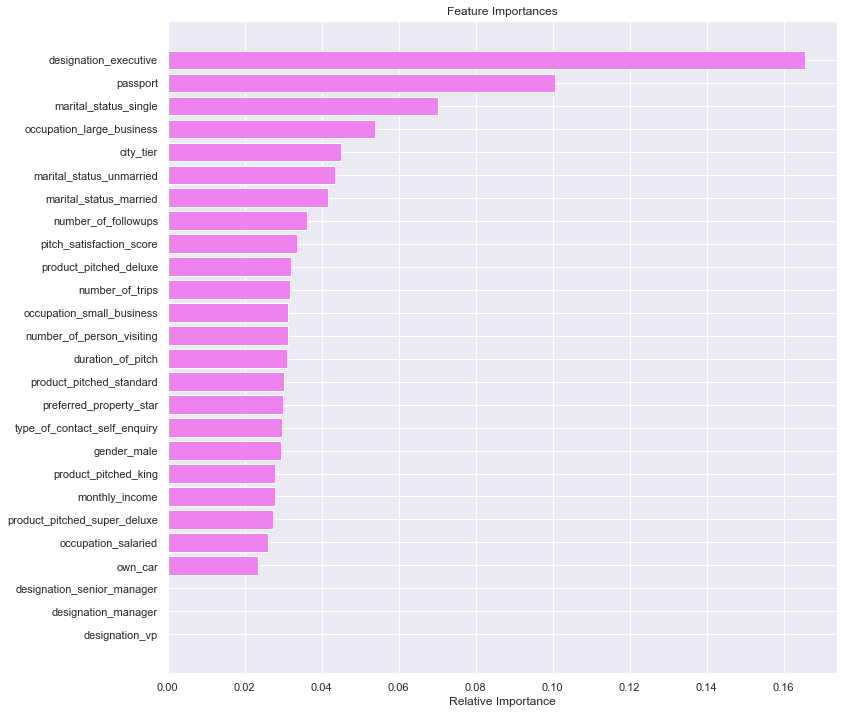

In [56]:
importances = xgb.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Tuning of Boosting

### Tuning of AdaBoost

In [57]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1.3000000000000003, n_estimators=100,
                   random_state=1)

In [58]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_tuned_score=get_metrics_score(abc_tuned)

Accuracy on training set :  0.9841979725700656
Accuracy on test set :  0.8845618915159944
Recall on training set :  0.944620253164557
Recall on test set :  0.5977859778597786
Precision on training set :  0.9707317073170731
Precision on test set :  0.7397260273972602


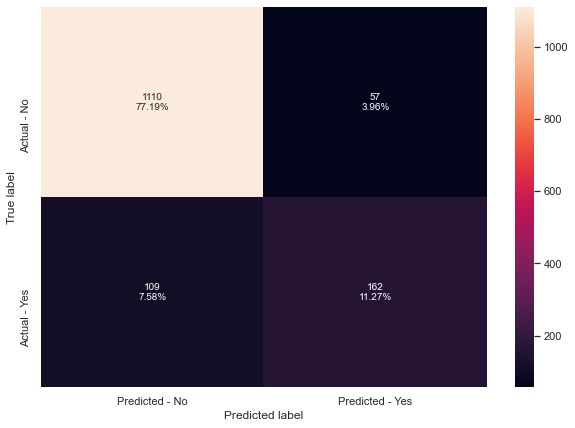

In [59]:
make_confusion_matrix(abc_tuned,y_test)

#### Observation : Tuned Adaboost
- Precision on test data has increased from 68% to 73%
- But Model seems to be slightly overfit

#### Feature importance : AdABoost Tuned

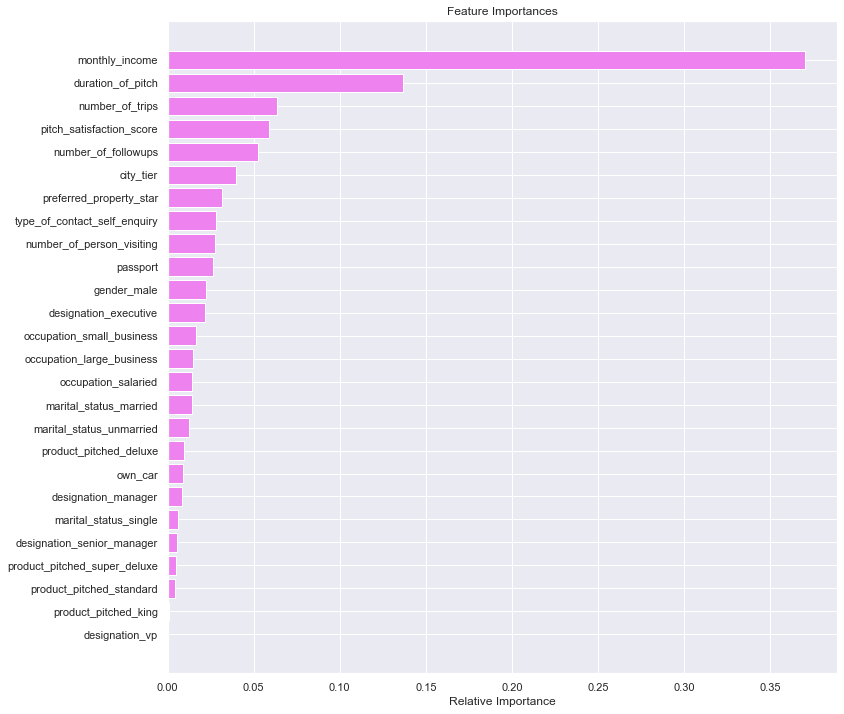

In [60]:
importances = abc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Tuning of Gradient Boosting Classifier

In [61]:
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
gbc_init.fit(X_train,y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           random_state=1)

In [62]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_init_score=get_metrics_score(gbc_init)

Accuracy on training set :  0.8813357185450209
Accuracy on test set :  0.8539638386648123
Recall on training set :  0.4541139240506329
Recall on test set :  0.33948339483394835
Precision on training set :  0.8441176470588235
Precision on test set :  0.7479674796747967


In [63]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.8, n_estimators=250, random_state=1,
                           subsample=0.9)

In [64]:
gbc_tuned_score=get_metrics_score(gbc_tuned)

Accuracy on training set :  0.9165175909361956
Accuracy on test set :  0.8720445062586927
Recall on training set :  0.6123417721518988
Recall on test set :  0.43911439114391143
Precision on training set :  0.9170616113744076
Precision on test set :  0.7880794701986755


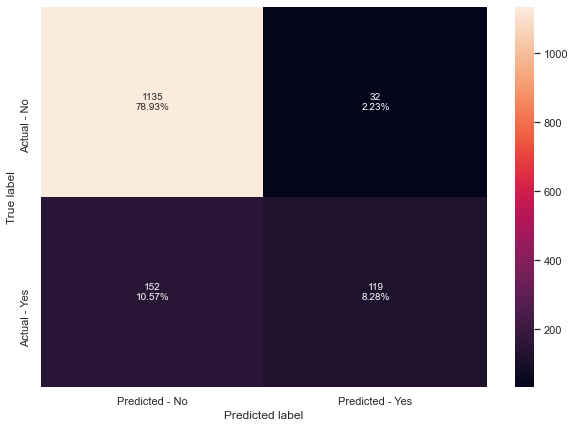

In [65]:
make_confusion_matrix(gbc_tuned,y_test)

#### Observation : Tuned Gradient Boost
- Precision on test data has increased from 75% to 78%
- Model seems to fit well

#### Feature Importance : Gradient Boosting Tuned

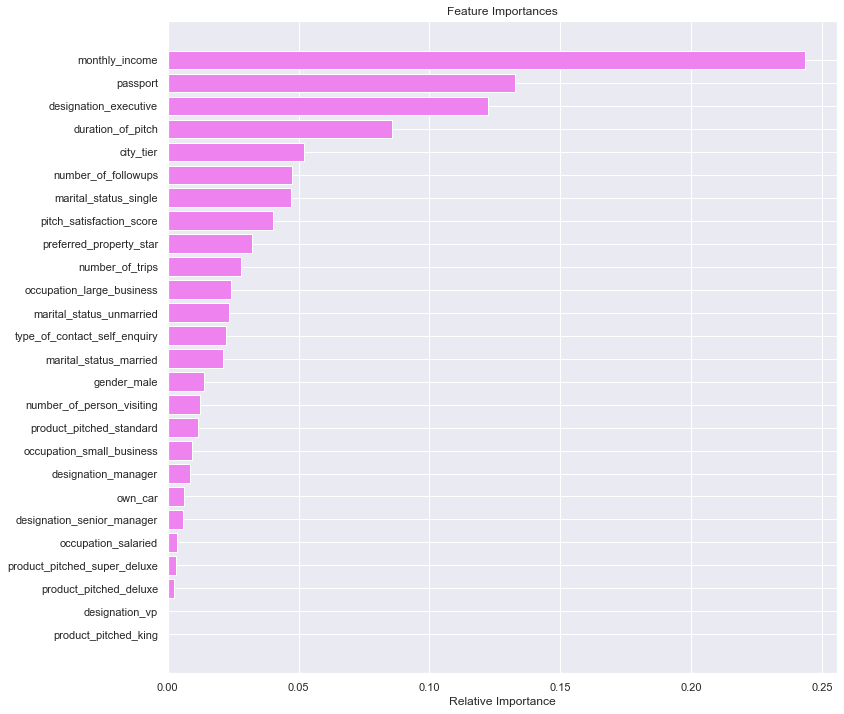

In [66]:
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Tuning of XGBoost (Xgboost tuning took few hours on below parameters)

Accuracy on training set :  0.9713774597495528
Accuracy on test set :  0.89221140472879
Recall on training set :  0.8670886075949367
Recall on test set :  0.5498154981549815
Precision on training set :  0.9785714285714285
Precision on test set :  0.8186813186813187


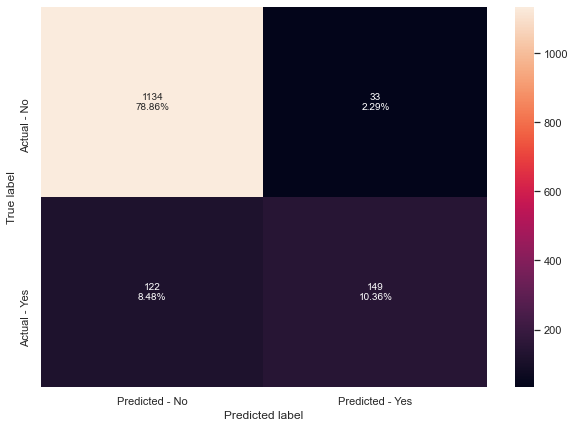

In [67]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(1000),
    "scale_pos_weight":[1],
    "subsample":[0.8],
    "learning_rate":[0.1],
    "gamma":[1],
    "max_depth": [3],
    "colsample_bytree":[1],
    "colsample_bylevel":[1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

#Using above defined function to get accuracy, recall and precision on train and test set
xgb_tuned_score=get_metrics_score(xgb_tuned)

make_confusion_matrix(xgb_tuned,y_test)


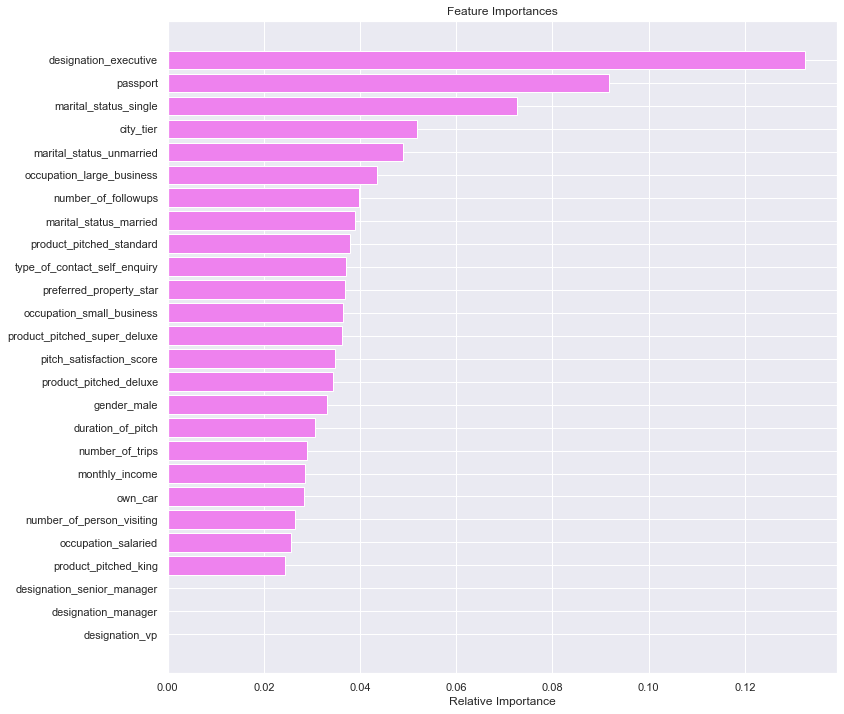

In [69]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Model Comparison

| Model Name | training_accuracy | testing_accuracy | precision | recall | f1_score | roc_auc_score
| --- | --- | --- | --- | --- | --- | -- |
| Decision Tree | 1 | 0.893 | 0.705 | 0.742 | 0.723 | 0.835
| Bagging | 0.993 | 0.909 | 0.872 | 0.605 | 0.715 | 0.792
| Random Forest | 0.993 | 0.909 | 0.872 | 0.605 | 0.715 | 0.792
| Tune Decision tree | 0.904 | 0.848 | 0.688 | 0.351 | 0.465 | 0.657
| Tune Bagging | 1 | 0.93 | 0.917 | 0.694 | 0.79 | 0.84
| Tune Random forest | 0.965 | 0.902 | 0.887 | 0.55 | 0.679 | 0.767


|Model Name | training_accuracy | testing_accuracy | training_recall | testing_recall | training_precision | testing_precision
| --- | --- | --- | --- | --- | --- | -- |
| Adaboost | 0.845 | 0.844 | 0.33 | 0.34 | 0.68 | 0.67
| Gradient Boost | 0.88 | 0.85 | 0.45 | 0.33 | 0.85 | 0.75
| Xgboost | 0.99 | 0.91 | 0.99 | 0.664 | 1 | 0.87 
| Tuned Adaboost | 0.98 | 0.88 | 0.94 | 0.597 | 0.97 | 0.73
| Tuned Gradient boost | 0.91 | 0.87 | 0.61 | 0.43 | 0.91 | 0.78
| **Tuned XgBoost  | 0.97 | 0.89 | 0.86 | 0.54 | 0.97 | 0.82**


A few words on Recall and Precision : 

- Recall: Recall gives us an idea about when it’s actually yes, how often does it predict yes.
- Recall = TP / (TP + FN)
---------------------------------------------------------------------------------
- Precsion tells us about when it predicts yes, how often is it correct.
- Precision = TP / (TP + FP)

<span style='color:Blue'>
In our use-case , Precision seems more important than recall as we want to see how often our predicted value is correct

Based on above observation - it seems **Tuned xgboost performed well** t</span>

# Recommendation & Insights

``` A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels.```

``` A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels
```

**Best Model Recommendation**
- With current implementation, <span style='color:Blue'> **Tuned xgboost** can be utilized with better precision.</span>
- Xgboost can be tuned more on hyperparameters


**Feature Importance**
- With Xgboost model ,  people having
    - <span style='color:Blue'> People having designation as executive
    - <span style='color:Blue'> People having passport
    - <span style='color:Blue'> Martial status and City Tier</span>
- These parameters will likely determine potential customers and purchase Travel package 